# Forest Cover Type Prediction
The goal of this notebook is to classify the forest cover type designation whether 1,2,..,or 7.

* [1. Problem Definition](#0)
* [2. Getting Started](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)    
    * [4.2.Feature Selection](#3.2) 
* [5.Evaluate Algorithms and Models](#4)        
* [6. Model Tuning](#5)
* [7. Finalizing The Model](#5)

<a id='0'></a>
## 1. Problem Definition

According to https://www.kaggle.com/c/forest-cover-type-prediction/data, in this dataset, each observation is a 30 meters x 30 meters patch, which came from four wilderness areas located in the Roosevelt National Forest of northern Colorado. We are tasked to predict an integer classification for the forest cover type:  
1. Spruce/Fir   
2. Lodgepole Pine  
3. Ponderosa Pine  
4. Cottonwood/Willow  
5. Aspen  
6. Douglas-fir  
7. Krummholz  

And the predictors are:  
1. Elevation - Elevation in meters  
1. Aspect - Aspect in degrees azimuth  
1. Slope - Slope in degrees  
1. Horizontal_Distance_To_Hydrology - Horz Dist to the nearest surface water features  
1. Vertical_Distance_To_Hydrology - Vert Dist to the nearest surface water features  
1. Horizontal_Distance_To_Roadways - Horz Dist to the nearest roadway  
1. Hillshade_9am (0 to 255 index) - Hillshade index at 9 am, the summer solstice  
1. Hillshade_Noon (0 to 255 index) - Hillshade index at noon, the summer solstice  
1. Hillshade_3pm (0 to 255 index) - Hillshade index at 3 pm, the summer solstice  
1. Horizontal_Distance_To_Fire_Points - Horz Dist to the nearest wildfire ignition points  
1. Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation  
1. Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation  
1. Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation  

The data can be downloaded from: https://www.kaggle.com/competitions/tabular-playground-series-dec-2021/overview

<a id='1'></a>
## 2. Getting Started

<a id='1.1'></a>
### 2.1 Loading Packages

In [ ]:
# Loading the data
import numpy as np
import pandas as pd

# Visualization
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import pycaret

import warnings
warnings.filterwarnings('ignore')


<a id='1.2'></a>
### 2.2 Loading Data

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

<a id='2'></a>
## 3. Exploratory Data Analysis

<a id='2.1'></a>
### 3.1 Descriptive Statistics

In [ ]:
# Checking Data Size.
print('Data Size: Test = ',len(test_df), ', Train = ', len(train_df))

Data Size: Test =  1000000 , Train =  4000000


Based on the result, it seems that we need to take a subset in order to reduce the runtime.

In [ ]:
# Checking How many columns are there.
print('Number of columns : Test = ',len(test_df.columns), ', Train = ', len(train_df.columns))

Number of columns : Test =  55 , Train =  56


In [ ]:
# Taking a peek at the data.
train_df.head(5)

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,0,3189,40,8,30,13,3270,206,234,193,...,0,0,0,0,0,0,0,0,0,1
1,1,3026,182,5,280,29,3270,233,240,106,...,0,0,0,0,0,0,0,0,0,2
2,2,3106,13,7,351,37,2914,208,234,137,...,0,0,0,0,0,0,0,0,0,1
3,3,3022,276,13,192,16,3034,207,238,156,...,0,0,0,0,0,0,0,0,0,2
4,4,2906,186,13,266,22,2916,231,231,154,...,0,0,0,0,0,0,0,0,0,2


We could see that there is a column called Id, which appears that it has unique values. The model wouldn't find it useful because there are no patterns since they are all unique. Therefore, we drop it.

In [ ]:
train_df.drop('Id',inplace=True,axis=1)
test_df.drop('Id',inplace=True,axis=1)

<a id='2.2'></a>
### 3.2 Data Visualization

<AxesSubplot:ylabel='Cover_Type'>

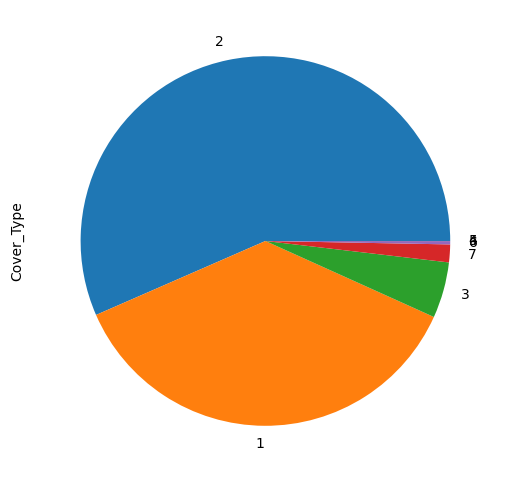

In [ ]:
train_df.Cover_Type.value_counts().plot.pie(figsize=(11, 6))

It appears that there is an extremely Imbalanced Classification. We could try to resolve it using under-sampling. However, there is insufficient data for 4-5-6 classes. Therefore, we wouldn't use it. It seems appropriate to use stratified k-fold cross-validation to resolve because it will enforce the class distribution in each split of the data to match the distribution in the complete training set.

<a id='3'></a>
### 4 Data Preparation

In [ ]:
# Since the dataset is large, we would do a random sample to obtain a subset.
train_sample = train_df.sample(n=40000, random_state=42)
test_sample = test_df.sample(n=40000, random_state=42)

<a id='3.1'></a>
### 4.1 Data Cleaning

In [ ]:
# Checking the data types
train_sample.dtypes.value_counts()

int64    55
dtype: int64

It seems that categorical variables have a continuous data type, for example, soil_type. Let's investigate more to make sure that's the case.

In [ ]:
# Thanks to Eduardo Gutierrez for this visualization https://www.kaggle.com/code/eduardogutierrez/tps-nov-21-exploratory-data-analysis-submission/notebook
train_sample.describe().T.sort_values(by='mean',ascending=False).style.background_gradient(cmap = 'Blues')\
                           .bar(subset = ["mean",], color = 'lightgreen')\
                           .bar(subset = ["std"], color = '#ee1f5f')\
                           .bar(subset = ["max"], color = '#FFA07A')

,count,mean,std,min,25%,50%,75%,max
Elevation,40000.000000,2981.743550,287.472714,1813.000000,2763.000000,2968.000000,3217.000000,4271.000000
Horizontal_Distance_To_Roadways,40000.000000,1769.595475,1320.067284,-238.000000,822.000000,1442.000000,2356.000000,7516.000000
Horizontal_Distance_To_Fire_Points,40000.000000,1577.029100,1125.550063,-218.000000,781.000000,1362.000000,2085.000000,8011.000000
Horizontal_Distance_To_Hydrology,40000.000000,271.807850,226.959837,-40.000000,111.000000,212.000000,361.000000,1544.000000
Hillshade_Noon,40000.000000,221.135225,22.281263,69.000000,210.000000,224.000000,237.000000,264.000000
Hillshade_9am,40000.000000,211.762550,30.680253,10.000000,198.000000,218.000000,233.000000,290.000000
Aspect,40000.000000,150.916900,109.952061,-29.000000,60.000000,121.000000,245.000000,393.000000
Hillshade_3pm,40000.000000,140.770200,43.858144,-46.000000,115.000000,142.000000,169.000000,268.000000
Vertical_Distance_To_Hydrology,40000.000000,51.236000,67.984478,-254.000000,4.000000,31.000000,77.000000,555.000000
Slope,40000.000000,15.109325,8.549757,-2.000000,9.000000,14.000000,20.000000,61.000000


Based on min and max, it seems like we have a mix between categorical variables and continuous. Let's check one last time. 

In [ ]:
categorical_var = []
continous_var = []
for col in train_sample.columns:
    if train_sample[col].nunique() == 2:
        categorical_var.append(col)
    else:
        if col != 'Cover_Type':
            continous_var.append(col)
len(categorical_var)

42

It seems like that is the case.

In [ ]:
# converting all categorical variables from int to bool
for col in categorical_var:
    test_sample[col] = test_sample[col].astype('bool')
    train_sample[col] = train_sample[col].astype('bool')

In [ ]:
# Checking each variable in order to have the correct data format.
train_sample.loc[:,continous_var].describe().T.sort_values(by='mean',ascending=False).style.background_gradient(cmap = 'Blues')\
                           .bar(subset = ["mean",], color = 'green')\
                           .bar(subset = ["std"], color = '#ee1f5f')\
                           .bar(subset = ["max"], color = '#FFA07A')

,count,mean,std,min,25%,50%,75%,max
Elevation,40000.000000,2981.743550,287.472714,1813.000000,2763.000000,2968.000000,3217.000000,4271.000000
Horizontal_Distance_To_Roadways,40000.000000,1769.595475,1320.067284,-238.000000,822.000000,1442.000000,2356.000000,7516.000000
Horizontal_Distance_To_Fire_Points,40000.000000,1577.029100,1125.550063,-218.000000,781.000000,1362.000000,2085.000000,8011.000000
Horizontal_Distance_To_Hydrology,40000.000000,271.807850,226.959837,-40.000000,111.000000,212.000000,361.000000,1544.000000
Hillshade_Noon,40000.000000,221.135225,22.281263,69.000000,210.000000,224.000000,237.000000,264.000000
Hillshade_9am,40000.000000,211.762550,30.680253,10.000000,198.000000,218.000000,233.000000,290.000000
Aspect,40000.000000,150.916900,109.952061,-29.000000,60.000000,121.000000,245.000000,393.000000
Hillshade_3pm,40000.000000,140.770200,43.858144,-46.000000,115.000000,142.000000,169.000000,268.000000
Vertical_Distance_To_Hydrology,40000.000000,51.236000,67.984478,-254.000000,4.000000,31.000000,77.000000,555.000000
Slope,40000.000000,15.109325,8.549757,-2.000000,9.000000,14.000000,20.000000,61.000000


There are variables that aren't aligned with their variable description, such as Hillshade_9am, Hillshade_Noon, and Hillshade_3pm, because they are supposed to be around 0 to 255 index, based on the variable description.

In [ ]:
train_sample['Hillshade_Noon'].clip(lower=0,upper=255,inplace=True)
train_sample['Hillshade_9am'].clip(lower=0,upper=255,inplace=True)
train_sample['Hillshade_3pm'].clip(lower=0,upper=255,inplace=True)

test_sample['Hillshade_Noon'].clip(lower=0,upper=255,inplace=True)
test_sample['Hillshade_9am'].clip(lower=0,upper=255,inplace=True)
test_sample['Hillshade_3pm'].clip(lower=0,upper=255,inplace=True)

The aspect is in degrees azimuth, meaning it should be from 0 to 359.
Thanks to Gulshan Mishra https://www.kaggle.com/code/gulshanmishra/tps-dec-21-tensorflow-nn-feature-engineering/notebook#Part-2:-Feature-Engineering for the insight

In [ ]:
train_sample["Aspect"][train_sample["Aspect"] < 0] += 360
train_sample["Aspect"][train_sample["Aspect"] > 359] -= 360

test_sample["Aspect"][test_sample["Aspect"] < 0] += 360
test_sample["Aspect"][test_sample["Aspect"] > 359] -= 360

<a id='3.2'></a>
### 4.2 Feature Selection

It seems like Soil_Type15 and Soil_Type7 don't do anything based on summary statistics, such as mean, std, min and max. Therefore, dropping them seems appropriate.

In [ ]:
train_sample.drop(columns=['Soil_Type15','Soil_Type7'],inplace=True)
test_sample.drop(columns=['Soil_Type15','Soil_Type7'],inplace=True)

<AxesSubplot:>

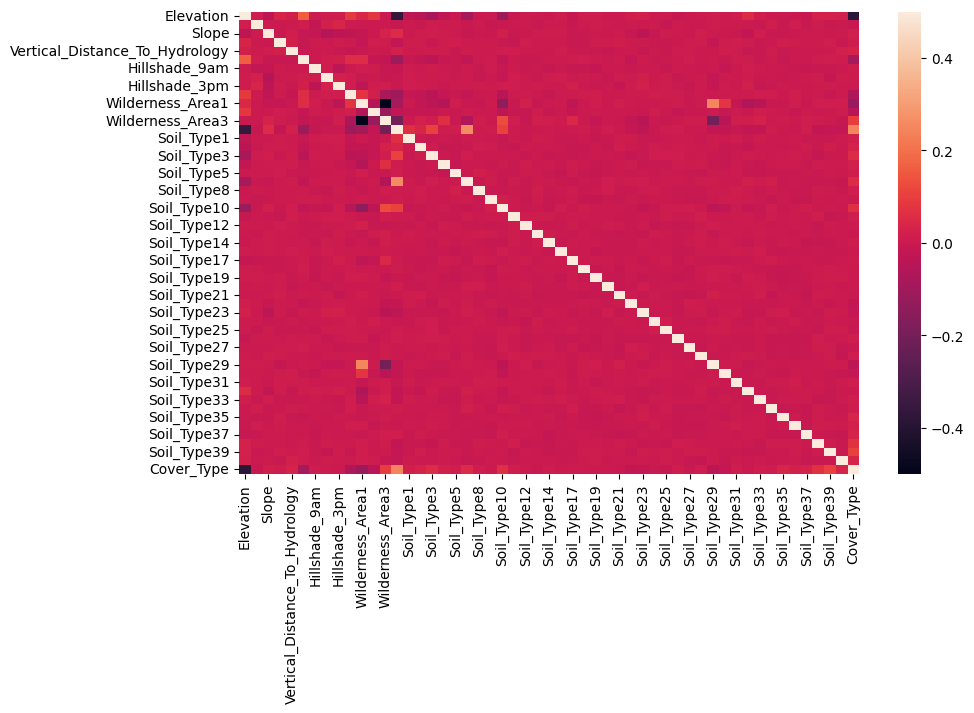

In [ ]:
# now we explore the correlations
plt.figure(figsize=(10, 6))
sns.heatmap(train_sample.corr(), vmin=-0.5, vmax=0.5)

Based on the heatmap, There are correlations between variables, such as Elevation and Wilderness_Area3.

Thanks to Samuel Cortinhas https://www.kaggle.com/code/samuelcortinhas/tps-dec-eda-feat-eng-pseudolab#Introduction for the idea of creating Euclidean distance to Hydrology using Horizontal_Distance_To_Hydrology and Vertical_Distance_To_Hydrology.

In [ ]:
train_sample["ecldn_dist_hydrlgy"] = (train_sample["Horizontal_Distance_To_Hydrology"]**2 + train_sample["Vertical_Distance_To_Hydrology"]**2)**0.5
test_sample["ecldn_dist_hydrlgy"] = (test_sample["Horizontal_Distance_To_Hydrology"]**2 + test_sample["Vertical_Distance_To_Hydrology"]**2)**0.5

<a id='4'></a>
## 5. Evaluate Algorithms and Models

In [ ]:
from pycaret.classification import *
#s = setup(train_sample,target='Cover_Type',use_gpu=True)

In [ ]:
#best = compare_models()

<a id='5'></a>
## 6. Model Tuning

In [ ]:
#tuned_best = tune_model(best)

<a id='6'></a>
## 7. Finalizing The Model

In [ ]:
#final_model = finalize_model(tuned_best)

Saving the model

In [ ]:
##save_model(final_model,'Final RF Model')

<a id='7'></a>
## 8. Loading The Model

To reduce the runtime and to show the result faster, we would load the pretrained model.

In [ ]:
loaded_model = load_model('Final RF Model')

Transformation Pipeline and Model Successfully Loaded


In [ ]:
predict_model(loaded_model,data=test_sample, raw_score=True)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,ecldn_dist_hydrlgy,Label,Score_0,Score_1,Score_2,Score_3,Score_4,Score_5
987231,2706,177,17,172,268,324,234,253,166,1510,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,318.446228,2,0.0001,0.9843,0.0155,0.0000,0.0000,0.0000
79954,2825,350,17,102,49,1173,234,195,86,975,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,113.159180,2,0.0006,0.9898,0.0095,0.0000,0.0001,0.0000
567130,3468,203,2,184,-6,389,224,227,104,574,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,184.097800,1,0.9971,0.0001,0.0000,0.0000,0.0000,0.0027
500891,2492,20,13,24,206,1138,213,228,108,284,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,207.393346,2,0.0007,0.4765,0.3931,0.0057,0.1235,0.0005
55399,3098,51,25,162,66,209,227,165,161,5243,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,174.928557,2,0.3364,0.6630,0.0004,0.0000,0.0000,0.0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527015,2801,28,33,475,7,172,239,218,160,2337,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,475.051576,2,0.0205,0.9790,0.0003,0.0000,0.0001,0.0001
889363,2932,336,12,216,-3,4170,240,233,170,1125,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,216.020832,2,0.0013,0.9984,0.0003,0.0000,0.0000,0.0000
802306,2885,163,13,386,71,1337,186,236,140,6333,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,392.475477,2,0.0178,0.9802,0.0017,0.0001,0.0001,0.0001
975108,3142,336,9,446,63,152,202,229,199,1027,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa